## 0- import Section 📚

In [2]:
#region imports
%load_ext autoreload 
%autoreload 2 
import pandas as pd
import random
from sklearn.neighbors import KNeighborsRegressor
from sklearn import set_config
set_config(display="diagram");

RANDOMSEED = 100
DISPLAY_WIDTH = 400
DISPLAYMAX_COLUMNS = 25

random.seed(RANDOMSEED)
pd.set_option('display.width', DISPLAY_WIDTH)
pd.set_option('display.max_columns', DISPLAYMAX_COLUMNS)
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

import numpy as np
import shap
import pickle

# %pwd # to see thecurrent directory
%cd '/home/ashamsa/code/pc/pde_cap_mrp_zagros'
from mrputils.loaders import DataLoader
from mrputils.processors import tweak_data,tweak_data4_prediction

#endregion

/home/ashamsa/.pyenv/versions/3.8.12/envs/.pde_cap_small/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


/home/ashamsa/code/pc/pde_cap_mrp_zagros


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ashamsa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ashamsa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ashamsa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ashamsa/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 1- import data

In [3]:
# %cd '/home/ashamsa/code/pc/pde_cap_mrp_zagros'
# from mrputils_.mrputils.loaders import DataLoader
# from mrputils_.mrputils.processors import tweak_data,tweak_data4_prediction

In [4]:
dp=DataLoader("data")
dp.get_data() #loading all the data

df_awards,df_all_casting,df_all_details,data_awards_cleaned=dp.df_awards,dp.df_all_casting,dp.df_all_details,dp.data_awards_cleaned

__,df_nulls=tweak_data(df_all_casting,df_all_details,data_awards_cleaned)

starting class


The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
The default value of numeric_only in DataFrameGroupBy.cumsum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.cumsum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


## 2- defining X,y  📚

In [5]:
X=df_nulls.drop(columns=["id","revenue","popularity"])
X_with_id=df_nulls.drop(columns=["revenue","popularity"])
y=df_nulls[["revenue","popularity"]]
target_1=y.iloc[:,0]
target_2=y.iloc[:,1]

## 3- import all models


In [6]:
import pickle
M=pickle.load(open('models/finalized_model.sav',"rb")) # model for revenue
preprocessor=pickle.load(open('models/preprocessor_x.sav',"rb")) #processor #1
preprocessor_with_id=pickle.load(open('models/preprocessor_x_id.sav',"rb")) # processor #2
M_pop=pickle.load(open('models/popularity.sav',"rb"))#model popularity
knn_model=pickle.load(open('models/knn_similarity.sav',"rb"))
m_fit=pickle.load(open('models/final_estimator.sav',"rb"))#for shap analysis

unclosed file <_io.BufferedReader name='models/finalized_model.sav'>
unclosed file <_io.BufferedReader name='models/preprocessor_x.sav'>
unclosed file <_io.BufferedReader name='models/preprocessor_x_id.sav'>
unclosed file <_io.BufferedReader name='models/popularity.sav'>
unclosed file <_io.BufferedReader name='models/knn_similarity.sav'>
unclosed file <_io.BufferedReader name='models/final_estimator.sav'>


## 4- Prediction

In [7]:
#sample record format for prediction; sample data called xx
id=597
record_data=df_all_details.query("id==@id")
record_casting=df_all_casting.query("id==@id")
xx=tweak_data4_prediction(df_all_casting,record_casting,df_all_details,record_data,data_awards_cleaned)
xx

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
The default value of numeric_only in DataFrameGroupBy.cumsum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.cumsum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,budget,original_language,production_countries,runtime,spoken_languages,production_companies_number,production_countries_number,day_of_week,age,sin_month,cos_month,action,...,thriller,tv,war,western,actor1_name,actor2_name,actor3_name,actor4_name,actor5_name,director_freq,fame_nominated,fame_won
8657,200000000,1,1,194.0,1,3,1,1.0,28.0,-0.866025,0.5,0,...,1,0,0,0,4.0,6.0,1.0,5.0,8.0,6.0,8.0,18.0


In [8]:
M.predict(xx) #prediction

array([1.7235707e+09], dtype=float32)

## 5- Finding similar movies

In [9]:
xx_processed=preprocessor.transform(xx)#sample processed
X_with_id_processed=pd.DataFrame(preprocessor_with_id.transform(X_with_id),columns=preprocessor_with_id.get_feature_names_out())
X_processed=pd.DataFrame(preprocessor.transform(X),columns=preprocessor.get_feature_names_out())

In [10]:
num_neighbors=5 # Return the distances and index of the 2 closest points
similars=list(knn_model.kneighbors(xx_processed,n_neighbors=num_neighbors)[1][0])
similar_ids=list(X_with_id_processed.iloc[similars].remainder__id.values)
df_all_details.query('id  in @similar_ids')[["id","title","genres","release_date","revenue","popularity"]].merge(
    df_all_casting.query('id  in @similar_ids')[["id","director_name","actor1_name","actor2_name","actor3_name"]],on="id"
)

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names


,id,title,genres,release_date,revenue,popularity,director_name,actor1_name,actor2_name,actor3_name
0,58,Pirates of the Caribbean: Dead Man's Chest,Adventure|Fantasy|Action,20/06/2006,1065659812,10.493411,Gore Verbinski,Johnny Depp,Orlando Bloom,Keira Knightley
1,597,Titanic,Drama|Romance|Thriller,18/11/1997,1845034188,10.517521,James Cameron,Kate Winslet,Leonardo DiCaprio,Frances Fisher
2,14161,2012,Action|Adventure|Science Fiction,10/10/2009,769653595,5.268971,Roland Emmerich,John Cusack,Amanda Peet,Chiwetel Ejiofor
3,37724,Skyfall,Action|Adventure|Thriller,25/10/2012,1108561013,9.818739,Sam Mendes,Daniel Craig,Judi Dench,Javier Bardem
4,102382,The Amazing Spider-Man 2,Action|Adventure|Fantasy,16/04/2014,705717432,6.966996,Marc Webb,Andrew Garfield,Emma Stone,Jamie Foxx


## 6- model predict popularity

In [11]:
M_pop.predict(xx) #prediction

array([9.8802595], dtype=float32)

## 7- model explenation

In [12]:
shap_values = np.load('models/shap_values.npy') # load
expected_value = float(np.load('models/expected_value.npy')) # load

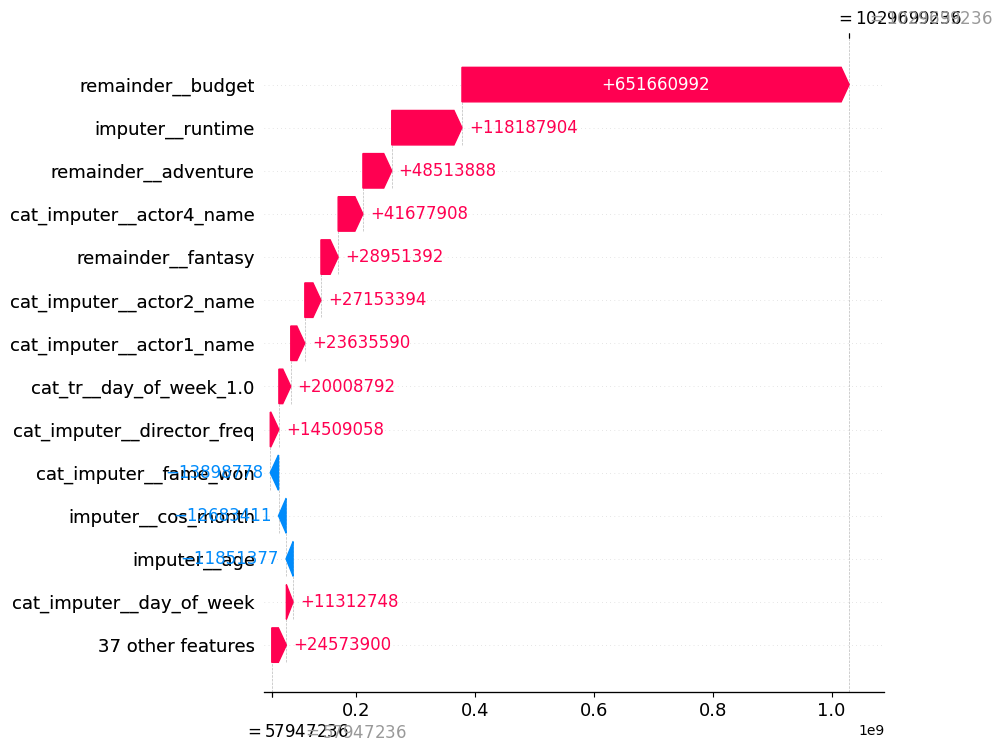

In [13]:
similars
i=similars[2]
shap.plots._waterfall.waterfall_legacy(expected_value, shap_values[i],feature_names=X_processed.columns,max_display = 14)

In [14]:
shap.initjs()
shap.force_plot(expected_value, shap_values[i], features=X_processed.iloc[i], feature_names=X_processed.columns)

In [26]:
ss=pd.Series(shap_values[i],index=X_processed.columns)

In [31]:
s1=np.sign(ss)

In [36]:
s2=ss.map(lambda x : x).abs().sort_values(ascending = False)

In [38]:
s3=s2*s1